In [1]:
import os
import copy

import numpy as np

from nems import Model, visualization

In [2]:
# load data (download if necessary)
signals_dir = "/auto/data/nems_db/recordings"
basename = 'TAR010c-18-2.npz'
datafile = os.path.join(signals_dir, basename)

if not os.path.exists(datafile):
    print(f"Need to download demo data file {datafile}")
    import requests
    prefix = 'https://s3-us-west-2.amazonaws.com/nemspublic/sample_data/'
    uri = prefix + basename
    r = requests.get(uri, stream=True)
    with open(datafile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    
d = np.load(datafile)

cellid = 'TAR010c-18-2'
fs = 100
X_est=d['X_est']
Y_est=d['Y_est']
X_val=d['X_val']
Y_val=d['Y_val']

In [3]:
# normalize stimulus peak to 1
X_norm = X_est.max()
X_est /= X_norm
X_val /= X_norm

In [4]:
modelspec = 'wc.18x1-fir.15x1-relu.1.o.s'
model0 = Model.from_keywords(modelspec)
model0.sample_from_priors();

## Scipy backend fit

In [5]:
model_sci = copy.deepcopy(model0)

print('Backend: scipy, Fitting without NL ...')
model_sci.layers[-1].skip_nonlinearity=True
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'maxiter': 50}})

print('Backend: scipy, Now fitting with NL ...')
model_sci.layers[-1].skip_nonlinearity=False
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'maxiter': 100}})

Backend: scipy, Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00322638...
        Iteration 5, error is: 0.99729086...
        Iteration 10, error is: 0.96339283...
        Iteration 15, error is: 0.94782112...
        Iteration 20, error is: 0.92198351...
        Iteration 25, error is: 0.91444497...
        Iteration 30, error is: 0.90958056...
        Iteration 35, error is: 0.90910686...
        Iteration 40, error is: 0.90883536...
        Iteration 45, error is: 0.90875196...
Fit successful: False
Status: 1
Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Backend: scipy, Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 1.37688231...
        Iteration 5, error is: 0.90443882...
        Iteration 10, error is: 0.90265586...
Fit successful: False
Status: 2
Message: ABNORMAL_TERMINATION_IN_LNSRCH


prediction correlation: 0.570


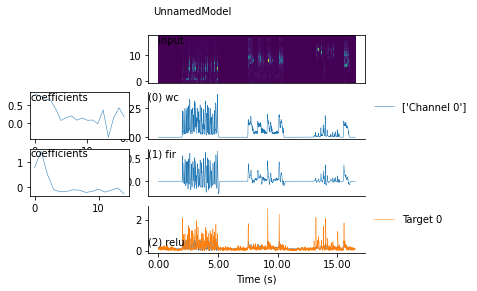

In [6]:
prediction = model_sci.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_sci, X_val, target=Y_val, sampling_rate=fs);

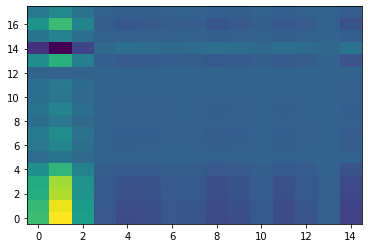

In [7]:
visualization.model.simple_strf(model_sci);

## TF backend fit

In [8]:
model_tf = copy.deepcopy(model0)

print('Backend: tf, Fitting without NL ...')
model_tf.layers[-1].skip_nonlinearity=True
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options={'learning_rate': 1e-3, 'epochs': 500},
          batch_size=None)

print('Backend: tf, Now fitting with NL ...')
model_tf.layers[-1].skip_nonlinearity=False
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options={'learning_rate': 1e-4, 'epochs': 500},
          batch_size=None)

Backend: tf, Fitting without NL ...


2022-08-25 10:01:49.717792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-25 10:01:50.380038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7285 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 1)          18        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         15        
 F)                                                              
                                                                 
 relu (RectifiedLinearTF)    (None, 49500, 1)          3         
                                                                 
Total params: 36
Trainable params: 35
Non-trainable params: 1
_________________________________________________________________
None


2022-08-25 10:01:51.469935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-08-25 10:01:51.471860: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-25 10:01:51.474330: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 1/500
1/1 [==============================] - 0s 261ms/step - loss: 1.0807
Epoch 2/500
1/1 [==============================] - 0s 4ms/step - loss: 1.0766
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 1.0726
Epoch 4/500
1/1 [==============================] - 0s 5ms/step - loss: 1.0686
Epoch 5/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0646
Epoch 6/500
1/1 [==============================] - 0s 7ms/step - loss: 1.0606
Epoch 7/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0567
Epoch 8/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0528
Epoch 9/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0489
Epoch 10/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0450
Epoch 11/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0411
Epoch 12/500
1/1 [==============================] - 0s 6ms/step - loss: 1.0373
Epoch 13/500
1/1 [==============================] - 0s 6ms/

1/1 [==============================] - 0s 8ms/step - loss: 0.6513
Epoch 105/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6470
Epoch 106/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6426
Epoch 107/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6383
Epoch 108/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6340
Epoch 109/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6297
Epoch 110/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6255
Epoch 111/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6212
Epoch 112/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6170
Epoch 113/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6128
Epoch 114/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6086
Epoch 115/500
1/1 [==============================] - 0s 8ms/step - loss: 0.6044
Epoch 116/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.3538
Epoch 207/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3525
Epoch 208/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3512
Epoch 209/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3500
Epoch 210/500
1/1 [==============================] - 0s 9ms/step - loss: 0.3487
Epoch 211/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3475
Epoch 212/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3463
Epoch 213/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3451
Epoch 214/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3439
Epoch 215/500
1/1 [==============================] - 0s 8ms/step - loss: 0.3428
Epoch 216/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3416
Epoch 217/500
1/1 [==============================] - 0s 7ms/step - loss: 0.3405
Epoch 218/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.2701
Epoch 309/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2695
Epoch 310/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2688
Epoch 311/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2682
Epoch 312/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2676
Epoch 313/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2670
Epoch 314/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2664
Epoch 315/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2658
Epoch 316/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2652
Epoch 317/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2645
Epoch 318/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2639
Epoch 319/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2633
Epoch 320/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.2161
Epoch 411/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2157
Epoch 412/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2152
Epoch 413/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2148
Epoch 414/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2144
Epoch 415/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2139
Epoch 416/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2135
Epoch 417/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2131
Epoch 418/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2126
Epoch 419/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2122
Epoch 420/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2118
Epoch 421/500
1/1 [==============================] - 0s 7ms/step - loss: 0.2114
Epoch 422/500
1/1 [==============================] - 0

2022-08-25 10:01:56.984572: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 1)          18        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         15        
 F)                                                              
                                                                 
 relu (RectifiedLinearTF)    (None, 49500, 1)          3         
                                                                 
Total params: 36
Trainable params: 35
Non-trainable params: 1
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 0s 220ms/step - loss: 0.1826
Epoch 2/500
1/1 [====

1/1 [==============================] - 0s 7ms/step - loss: 0.1756
Epoch 92/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1755
Epoch 93/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1754
Epoch 94/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1753
Epoch 95/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1753
Epoch 96/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1752
Epoch 97/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1751
Epoch 98/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1751
Epoch 99/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1750
Epoch 100/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1749
Epoch 101/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1748
Epoch 102/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1748
Epoch 103/500
1/1 [==============================] - 0s 7ms/st

1/1 [==============================] - 0s 8ms/step - loss: 0.1684
Epoch 194/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1683
Epoch 195/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1682
Epoch 196/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1682
Epoch 197/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1681
Epoch 198/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1681
Epoch 199/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1680
Epoch 200/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1679
Epoch 201/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1679
Epoch 202/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1678
Epoch 203/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1677
Epoch 204/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1677
Epoch 205/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 8ms/step - loss: 0.1620
Epoch 296/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1619
Epoch 297/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1619
Epoch 298/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1618
Epoch 299/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1618
Epoch 300/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1617
Epoch 301/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1617
Epoch 302/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1616
Epoch 303/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1615
Epoch 304/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1615
Epoch 305/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1614
Epoch 306/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1614
Epoch 307/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 7ms/step - loss: 0.1564
Epoch 398/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1563
Epoch 399/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1563
Epoch 400/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1562
Epoch 401/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1562
Epoch 402/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1561
Epoch 403/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1561
Epoch 404/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1560
Epoch 405/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1560
Epoch 406/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1559
Epoch 407/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1558
Epoch 408/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1558
Epoch 409/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 6ms/step - loss: 0.1514
Epoch 500/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1514


prediction correlation: 0.451


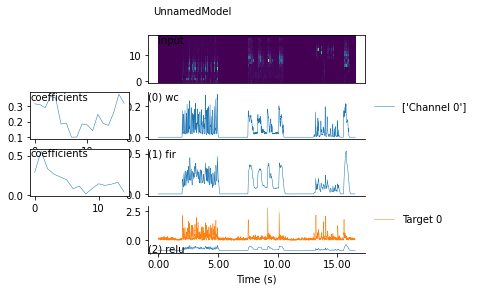

In [9]:
prediction = model_tf.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_tf, X_val, target=Y_val, sampling_rate=fs);

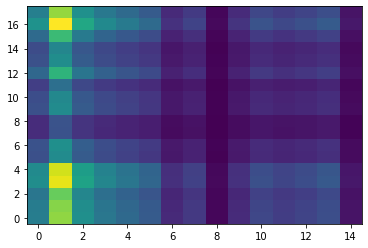

In [10]:
visualization.model.simple_strf(model_tf);